In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [4]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

system_settings = {
    "surface_name": "SrTiO3(001)",
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0,  # no annealing
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 5,
}

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

Obtain adsorption sites

In [5]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([ 7.871,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829])]...


In [6]:
pristine_slab.get_tags()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [7]:
import torch
from nff.io.ase import AtomsBatch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [8]:
# set attributes
slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=system_settings["cutoff"],
    props={"energy": 0, "energy_grad": []},
    calculator=nff_surf_calc,
    requires_large_offsets=False,
    directed=True,
    device=DEVICE,
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

surface = SurfaceSystem(
    slab_batch, ads_positions, nff_surf_calc, system_settings=system_settings
)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]
ads coords is [ 7.871  7.941 18.87 ]
ads coords is [ 1.968  1.951 18.829]
ads coords is [ 1.968  0.146 18.782]
ads coords is [ 7.871  3.956 18.87 ]
ads coords is [ 1.968  5.936 18.829]
ads coords is [ 1.968  4.131 18.782]
ads coords is [ 3.936  7.941 18.87 ]
ads coords is [ 5.903  1.951 18.829]
ads coords is [ 5.903  0.146 18.782]
ads coords is [ 3.936  3.956 18.87 ]
ads coords is [ 5.903  5.936 18.829]
ads coords is [ 5.903  4.131 18.782]
ads coords is [ 1.968  7.026 18.806]
ads coords is [ 0.984  6.938 18.85 ]
ads coords is [ 5.903  7.026 18.806]
ads 

2024-04-18 18:59:07,019|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-04-18 18:59:07,019|INFO|number of pristine atoms is 60
2024-04-18 18:59:07,020|INFO|bulk indices are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
2024-04-18 18:59:07,021|INFO|surface indices are []


In [9]:
surface.get_potential_energy()

array([-467.543], dtype=float32)

In [9]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [10]:
from mcmc.energy import slab_energy

surf_energy, energy_std, max_force, force_std, pe_per_atom = slab_energy(
    surface, offset=True, offset_data=calc_settings["offset_data"]
)

print(f"Surface energy: {surf_energy} eV")

      Step     Time          Energy         fmax
BFGS:    0 17:20:06     -467.521881        0.0000
Surface energy: 12.49005126953125 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-04-18 17:20:08,096|INFO|there are 60 atoms in pristine slab
2024-04-18 17:20:08,099|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-04-18 17:20:08,100|INFO|In pristine slab, there are a total of 64 sites


      Step     Time          Energy         fmax
BFGS:    0 17:20:08     -467.521881        0.0000


2024-04-18 17:20:08,303|INFO|running for 5 iterations per run over a total of 10 runs
2024-04-18 17:20:08,304|INFO|starting with iteration 0
2024-04-18 17:20:08,305|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 17:20:08     -470.696198        2.9263
BFGS:    1 17:20:08     -470.817383        2.8640
BFGS:    2 17:20:08     -471.312378        1.8090
BFGS:    3 17:20:08     -471.442108        0.7272
BFGS:    4 17:20:08     -471.453644        0.2372
BFGS:    5 17:20:08     -471.454376        0.1820
BFGS:    6 17:20:08     -471.455536        0.0267
BFGS:    7 17:20:08     -471.455536        0.0249
BFGS:    8 17:20:09     -471.455566        0.0241
BFGS:    9 17:20:09     -471.455597        0.0225
BFGS:   10 17:20:09     -471.455658        0.0158
BFGS:   11 17:20:09     -471.455658        0.0060
      Step     Time          Energy         fmax
BFGS:    0 17:20:09     -469.891357        0.6995
BFGS:    1 17:20:09     -469.898285        0.6840
BFGS:    2 17:20:09     -470.012451        0.4821
BFGS:    3 17:20:09     -470.014069        1.3008
BFGS:    4 17:20:09     -470.031494        0.7865
BFGS: 

2024-04-18 17:20:21,190|INFO|current energy is 13.537109375, calculated energy is 13.537109375
2024-04-18 17:20:21,191|INFO|optim structure has Energy = 13.537+/-0.126
2024-04-18 17:20:21,193|INFO|average force error = 0.000
2024-04-18 17:20:21,221|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:20:21     -465.079071       21.3268
BFGS:    1 17:20:21     -469.676483       10.4717
BFGS:    2 17:20:21     -472.625977        5.9814
BFGS:    3 17:20:21     -474.198395        3.6012
BFGS:    4 17:20:22     -474.935883        2.4653
BFGS:    5 17:20:22     -475.225739        2.6816
BFGS:    6 17:20:22     -475.721100        2.8934
BFGS:    7 17:20:22     -476.113373        3.5316
BFGS:    8 17:20:22     -476.489166        3.9566
BFGS:    9 17:20:22     -476.958160        1.6988
BFGS:   10 17:20:22     -477.142242        1.2468
BFGS:   11 17:20:22     -477.371613        1.2363
BFGS:   12 17:20:23     -477.428955        1.3321
BFGS:   13 17:20:23     -477.503693        1.1401
BFGS:   14 17:20:23     -477.754974        0.6255
BFGS:   15 17:20:23     -477.831451        0.7495
BFGS:   16 17:20:23     -477.846924        1.0309
BFGS:   17 17:20:23     -477.867767        1.0613
BFGS:   18 17:20:23     -477.937592        1.0565
B

2024-04-18 17:20:35,970|INFO|current energy is 12.34283447265625, calculated energy is 12.34283447265625
2024-04-18 17:20:35,974|INFO|optim structure has Energy = 12.343+/-0.358
2024-04-18 17:20:35,975|INFO|average force error = 0.000
2024-04-18 17:20:35,986|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:20:36     -452.736938       51.1218
BFGS:    1 17:20:36     -464.743256       16.3654
BFGS:    2 17:20:36     -472.198090        9.9779
BFGS:    3 17:20:36     -477.693604        6.3015
BFGS:    4 17:20:36     -481.167023        5.1921
BFGS:    5 17:20:36     -483.324066        4.0089
BFGS:    6 17:20:36     -484.778229        3.0889
BFGS:    7 17:20:36     -485.767944        3.0565
BFGS:    8 17:20:36     -486.504639        3.7183
BFGS:    9 17:20:37     -487.120758        4.3001
BFGS:   10 17:20:37     -488.084961        3.2230
BFGS:   11 17:20:37     -489.148193        2.8283
BFGS:   12 17:20:37     -489.897614        2.6864
BFGS:   13 17:20:37     -490.151733        2.2432
BFGS:   14 17:20:37     -490.758636        2.2682
BFGS:   15 17:20:37     -491.286133        2.1296
BFGS:   16 17:20:37     -491.689209        1.9739
BFGS:   17 17:20:37     -491.910614        1.5586
BFGS:   18 17:20:37     -492.014313        1.3054
B

2024-04-18 17:20:47,049|INFO|current energy is 7.931732177734375, calculated energy is 7.93170166015625
2024-04-18 17:20:47,050|INFO|optim structure has Energy = 7.932+/-0.244
2024-04-18 17:20:47,050|INFO|average force error = 0.000
2024-04-18 17:20:47,059|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:20:47     -451.845673       51.1669
BFGS:    1 17:20:47     -467.593109       19.1740
BFGS:    2 17:20:47     -474.899811       10.6175
BFGS:    3 17:20:47     -480.294830        5.8120
BFGS:    4 17:20:47     -483.573883        4.5109
BFGS:    5 17:20:47     -485.322723        3.6123
BFGS:    6 17:20:47     -486.319946        2.9077
BFGS:    7 17:20:47     -486.854645        3.3285
BFGS:    8 17:20:47     -487.736115        3.6977
BFGS:    9 17:20:47     -489.153564        3.6984
BFGS:   10 17:20:47     -490.007477        7.8959
BFGS:   11 17:20:48     -490.967377        2.9433
BFGS:   12 17:20:48     -491.347015        3.2034
BFGS:   13 17:20:48     -491.803070        2.6515
BFGS:   14 17:20:48     -492.713257        1.9211
BFGS:   15 17:20:48     -493.072998        2.5039
BFGS:   16 17:20:48     -493.294769        2.5655
BFGS:   17 17:20:48     -493.817108        2.1523
BFGS:   18 17:20:48     -494.159210        2.1681
B

2024-04-18 17:20:58,439|INFO|current energy is 5.3050537109375, calculated energy is 5.305084228515625
2024-04-18 17:20:58,440|INFO|optim structure has Energy = 5.305+/-0.183
2024-04-18 17:20:58,440|INFO|average force error = 0.000
2024-04-18 17:20:58,450|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:20:58     -413.295776       59.6891
BFGS:    1 17:20:58     -456.204620       68.0820
BFGS:    2 17:20:58     -471.914581       21.6567
BFGS:    3 17:20:58     -484.552094       13.3411
BFGS:    4 17:20:58     -492.327850        7.4540
BFGS:    5 17:20:58     -497.088409        4.3534
BFGS:    6 17:20:59     -500.151520        3.8367
BFGS:    7 17:20:59     -502.397308        4.0022
BFGS:    8 17:20:59     -503.889679        3.8025
BFGS:    9 17:20:59     -504.754425        3.4225
BFGS:   10 17:20:59     -505.415863        3.1429
BFGS:   11 17:20:59     -506.827667        3.4291
BFGS:   12 17:20:59     -507.640472        2.5481
BFGS:   13 17:20:59     -508.314362        4.2800
BFGS:   14 17:20:59     -509.118927        4.1474
BFGS:   15 17:20:59     -509.943695        1.9238
BFGS:   16 17:20:59     -510.382172        1.6966
BFGS:   17 17:20:59     -510.662018        1.4673
BFGS:   18 17:21:00     -510.911041        1.5590
B

2024-04-18 17:21:09,701|INFO|current energy is 1.82342529296875, calculated energy is 1.82354736328125
2024-04-18 17:21:09,701|INFO|optim structure has Energy = 1.824+/-0.234
2024-04-18 17:21:09,702|INFO|average force error = 0.000
2024-04-18 17:21:09,711|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:21:09     -360.883698      119.4164
BFGS:    1 17:21:09     -416.734528       81.0208
BFGS:    2 17:21:09     -449.756500       37.1338
BFGS:    3 17:21:10     -469.374237       36.1451
BFGS:    4 17:21:10     -482.656403       20.5350
BFGS:    5 17:21:10     -492.588623       14.4963
BFGS:    6 17:21:10     -499.843872        8.5699
BFGS:    7 17:21:10     -504.495880        5.4516
BFGS:    8 17:21:10     -507.424225        4.3343
BFGS:    9 17:21:10     -509.551147        3.7332
BFGS:   10 17:21:10     -510.982452        2.9481
BFGS:   11 17:21:10     -511.676758        1.9711
BFGS:   12 17:21:10     -511.995850        1.9503
BFGS:   13 17:21:10     -512.437317        1.7981
BFGS:   14 17:21:10     -512.800293        1.6437
BFGS:   15 17:21:11     -513.086792        2.0185
BFGS:   16 17:21:11     -513.333191        1.9974
BFGS:   17 17:21:11     -513.683044        1.7167
BFGS:   18 17:21:11     -514.005310        1.8781
B

2024-04-18 17:21:20,993|INFO|current energy is 1.82342529296875, calculated energy is 1.82342529296875
2024-04-18 17:21:20,993|INFO|optim structure has Energy = 1.823+/-0.234
2024-04-18 17:21:20,994|INFO|average force error = 0.000
2024-04-18 17:21:21,002|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:21:21     -417.861053       58.8065
BFGS:    1 17:21:21     -459.239258       65.6023
BFGS:    2 17:21:21     -475.350983       22.0455
BFGS:    3 17:21:21     -489.928009       15.8366
BFGS:    4 17:21:21     -502.404663        9.7014
BFGS:    5 17:21:21     -510.156586        7.5965
BFGS:    6 17:21:21     -514.969116        5.8535
BFGS:    7 17:21:21     -518.126038        4.2477
BFGS:    8 17:21:21     -520.198547        3.1040
BFGS:    9 17:21:21     -521.669250        2.9049
BFGS:   10 17:21:21     -522.788330        3.2766
BFGS:   11 17:21:22     -523.629456        2.5706
BFGS:   12 17:21:22     -524.302673        3.0736
BFGS:   13 17:21:22     -524.771729        1.7117
BFGS:   14 17:21:22     -524.985840        1.5508
BFGS:   15 17:21:22     -525.601257        1.7137
BFGS:   16 17:21:22     -525.973083        1.5493
BFGS:   17 17:21:22     -526.359802        2.4440
BFGS:   18 17:21:22     -526.865295        2.3293
B

2024-04-18 17:21:32,819|INFO|current energy is 2.75140380859375, calculated energy is 2.75140380859375
2024-04-18 17:21:32,820|INFO|optim structure has Energy = 2.751+/-0.295
2024-04-18 17:21:32,820|INFO|average force error = 0.000
2024-04-18 17:21:32,829|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:21:32     -354.458374      115.5321
BFGS:    1 17:21:33     -396.969208      122.1743
BFGS:    2 17:21:33     -435.206665       72.4190
BFGS:    3 17:21:33     -428.286896      619.3121
BFGS:    4 17:21:33     -455.707367      323.6618
BFGS:    5 17:21:33     -475.011627      101.4070
BFGS:    6 17:21:33     -484.131195       40.1298
BFGS:    7 17:21:33     -494.046875       17.0726
BFGS:    8 17:21:33     -499.802094       19.0626
BFGS:    9 17:21:33     -503.216309        9.8451
BFGS:   10 17:21:33     -504.788177        5.1731
BFGS:   11 17:21:33     -505.478516        6.9288
BFGS:   12 17:21:33     -506.645477        4.2295
BFGS:   13 17:21:33     -507.472137        7.4091
BFGS:   14 17:21:34     -508.737762        4.4641
BFGS:   15 17:21:34     -509.654022        4.9856
BFGS:   16 17:21:34     -510.057617        4.7351
BFGS:   17 17:21:34     -510.333771        4.9696
BFGS:   18 17:21:34     -510.640839       15.5682
B

2024-04-18 17:21:44,157|INFO|current energy is 0.56842041015625, calculated energy is 0.56842041015625
2024-04-18 17:21:44,158|INFO|optim structure has Energy = 0.568+/-0.316
2024-04-18 17:21:44,158|INFO|average force error = 0.000
2024-04-18 17:21:44,170|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:21:44     -357.496582      118.0513
BFGS:    1 17:21:44     -415.983978       65.3343
BFGS:    2 17:21:44     -451.612152       40.4597
BFGS:    3 17:21:44     -471.144653       34.8879
BFGS:    4 17:21:44     -488.202881       19.2468
BFGS:    5 17:21:44     -500.796967       15.2032
BFGS:    6 17:21:44     -509.695526        8.7096
BFGS:    7 17:21:44     -515.561462        5.7410
BFGS:    8 17:21:44     -519.418762        5.3385
BFGS:    9 17:21:44     -522.633972        4.3782
BFGS:   10 17:21:45     -525.203552        4.8920
BFGS:   11 17:21:45     -526.901306        4.7972
BFGS:   12 17:21:45     -528.114197        4.5682
BFGS:   13 17:21:45     -529.405701        2.2177
BFGS:   14 17:21:45     -529.887939        1.8447
BFGS:   15 17:21:45     -530.295715        1.6395
BFGS:   16 17:21:45     -530.661499        1.8214
BFGS:   17 17:21:45     -531.153625        2.4690
BFGS:   18 17:21:45     -531.645081        2.3408
B

2024-04-18 17:21:55,544|INFO|current energy is 0.56842041015625, calculated energy is 0.56842041015625
2024-04-18 17:21:55,545|INFO|optim structure has Energy = 0.568+/-0.316
2024-04-18 17:21:55,546|INFO|average force error = 0.000
2024-04-18 17:21:55,555|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 17:21:55     -393.633209       73.8162
BFGS:    1 17:21:55     -439.796295       71.7516
BFGS:    2 17:21:55     -466.154633       39.3713
BFGS:    3 17:21:55     -487.525909       22.2418
BFGS:    4 17:21:55     -504.188202       11.8345
BFGS:    5 17:21:56     -513.892761        6.2296
BFGS:    6 17:21:56     -519.763977        4.3667
BFGS:    7 17:21:56     -523.511780        3.8672
BFGS:    8 17:21:56     -525.283630        4.7952
BFGS:    9 17:21:56     -526.274719        3.6504
BFGS:   10 17:21:56     -527.394287        2.4101
BFGS:   11 17:21:56     -528.120361        2.3125
BFGS:   12 17:21:56     -528.594299        1.9791
BFGS:   13 17:21:56     -528.954529        1.8211
BFGS:   14 17:21:56     -529.386292        2.0060
BFGS:   15 17:21:56     -529.697937        1.9671
BFGS:   16 17:21:56     -529.985596        1.7533
BFGS:   17 17:21:57     -530.345764        2.0043
BFGS:   18 17:21:57     -530.580017        2.0581
B

2024-04-18 17:22:07,069|INFO|current energy is 1.92999267578125, calculated energy is 1.92999267578125
2024-04-18 17:22:07,069|INFO|optim structure has Energy = 1.930+/-0.175
2024-04-18 17:22:07,070|INFO|average force error = 0.000


Time taken = 119.22591494396329 seconds


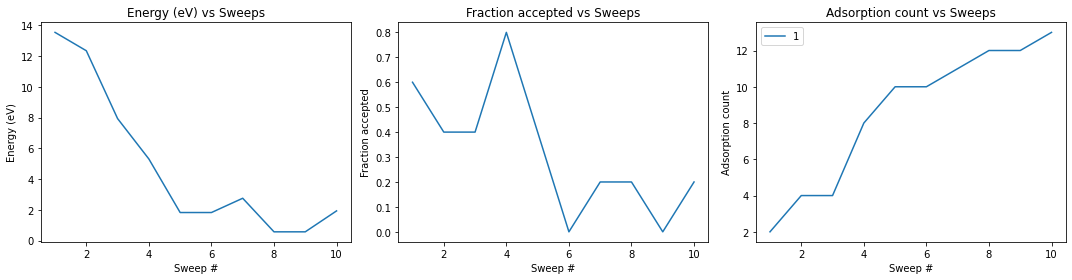

In [11]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=nff_surf_calc,
    canonical=False,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    offset=calc_settings["offset"],
    offset_data=calc_settings["offset_data"],
    optimizer=calc_settings["optimizer"],
)  # relax atoms with manual offset TODO fix this!

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [12]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)